# 0. Import Libraries

In [40]:
import azure.functions as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from datetime import date, timedelta
from shared_code import utils
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Initialize Storage Account

In [41]:
azure_utils = utils.AzureUtils()
secret_client = azure_utils.initialize_key_vault()

sa_secret = azure_utils.get_key_vault_secret(secret_client, 'sa-booli')
sa_name = azure_utils.get_key_vault_secret(secret_client, 'sa-name')
storage_account = azure_utils.initialize_storage_account_ad(sa_secret.value, sa_name.value)

# 2. Loading Data

In [42]:
utils_DataFactory = utils.DataFactory()
data_cleaning = utils_DataFactory.get_formatter("Cleaning")

columns_to_drop = ["floor", "soldPriceAbsoluteDiff", "soldPricePercentageDiff", "__typename", "listPrice", "rooms", "soldSqmPrice", "livingArea", "rent"]
non_numeric_columns = ["streetAddress", "objectType", "descriptiveAreaName", "soldPriceType", "soldDate", "url", "__typename"]
columns_to_rename = {
    "soldPrice.raw": "soldPriceInSek",
    "floor.raw": "floorNumber",
    "rent.raw": "rentInSek",
    "soldSqmPrice.raw": "soldSqmPriceInSek",
    "soldPriceAbsoluteDiff.raw": "soldPriceVsListPriceDiffInSek",
    "soldPricePercentageDiff.raw": "soldPriceVsListPriceDiffInPercentage",
    "listPrice.raw": "listPriceInSek",
    "livingArea.raw": "livingAreaInSqm",
    "rooms.raw": "numberOfRooms"
}

df = (
    azure_utils.ingest_raw_data("sold/Sold_Lägenhet")
    .pipe(data_cleaning.drop_dataframe_columns, columns_to_drop)
    .pipe(data_cleaning.set_dtype_to_numeric, non_numeric_columns)
    .pipe(data_cleaning.change_timestamp_format, "soldDate")
    .pipe(data_cleaning.rename_df_columns, columns_to_rename)
)
df.head()

,booliId,streetAddress,constructionYear,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber
0,1297209,Drottningholmsvägen 48,2011.0,Lägenhet,St Göran,Slutpris,18.0,2012-11-06,59.332038,18.022488,/bostad/342585,2650000,2193.0,63095.0,0.0,0.0,2650000.0,42.0,2.0,NaN
1,1309519,Lilla Västerbron 6,2009.0,Lägenhet,Fredhäll,Slutpris,13.0,2012-11-21,59.331375,18.023321,/annons/1309519,2650000,2989.0,63095.0,150000.0,6.0,2500000.0,42.0,2.0,NaN
2,1313807,Igeldammsgatan 20,1932.0,Lägenhet,St Göran,Slutpris,13.0,2012-11-28,59.336983,18.024736,/annons/1313807,2110000,1708.0,57027.0,110000.0,5.5,2000000.0,37.0,1.5,2.0
3,1284962,Hjärnegatan 4,NaN,Lägenhet,Kungsholmen,Slutpris,13.0,2012-10-17,59.332541,18.042303,/annons/1284962,2970000,2809.0,54000.0,-30000.0,-1.0,3000000.0,55.0,2.0,4.0
4,1282231,Vänskapsvägen 55,NaN,Lägenhet,Stora Essingen,Slutpris,25.0,2012-10-24,59.321561,17.988416,/bostad/792125,2000000,3698.0,41667.0,-200000.0,-9.1,2200000.0,48.0,2.5,3.0


# 3. General Statistics of the Dataframe

## Data Types

In [43]:
data_cleaning.get_data_types(df)

,Data Type
booliId,int64
streetAddress,object
constructionYear,float64
objectType,object
descriptiveAreaName,object
soldPriceType,object
daysActive,float64
soldDate,datetime64[ns]
latitude,float64
longitude,float64


## Statistical Overview

In [44]:
df.describe()

,booliId,constructionYear,daysActive,latitude,longitude,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber
count,9.656900e+04,88026.000000,95978.000000,96569.000000,96569.000000,9.656900e+04,90883.000000,96427.000000,9.287700e+04,9.287700e+04,9.289000e+04,96427.000000,96322.000000,87107.000000
mean,3.149446e+06,1934.214005,21.394601,59.331946,18.053059,5.470226e+06,2737.223463,92790.551806,4.243338e+05,1.463707e+03,4.972040e+06,59.301309,2.273011,2.993075
std,1.153055e+06,37.190698,39.624094,0.013089,0.027968,3.450260e+06,1272.096168,21580.159218,5.279015e+05,4.429751e+05,3.186367e+06,30.249108,1.021773,2.148916
min,-1.015519e+07,1300.000000,0.000000,59.279156,17.873617,4.000000e+04,1.000000,10000.000000,-6.029043e+06,-7.430000e+01,0.000000e+00,9.400000,1.000000,-3.000000
25%,2.062546e+06,1912.000000,11.000000,59.318600,18.033279,3.350000e+06,1861.000000,78289.000000,1.000000e+05,2.200000e+00,2.995000e+06,38.000000,2.000000,1.500000
50%,3.313559e+06,1930.000000,13.000000,59.334946,18.051577,4.500000e+06,2487.000000,91279.000000,3.550000e+05,9.300000e+00,3.995000e+06,53.000000,2.000000,3.000000
75%,4.124350e+06,1941.000000,19.000000,59.342275,18.077786,6.500000e+06,3389.000000,105333.000000,6.400000e+05,1.630000e+01,5.975000e+06,74.000000,3.000000,4.000000
max,4.852827e+06,2023.000000,2832.000000,59.373271,18.142138,1.350000e+08,35803.000000,755556.000000,1.500000e+07,1.349999e+08,7.500000e+07,970.000000,19.000000,99.900000


## Missing Values

In [45]:
def get_missing_values_percent(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    dropped_columns = missing_data[missing_data.Percent >= 0.5].index
    print(missing_data)

In [46]:
get_missing_values_percent(df)

                                      Total   Percent
floorNumber                            9462  0.097982
constructionYear                       8543  0.088465
rentInSek                              5686  0.058880
soldPriceVsListPriceDiffInPercentage   3692  0.038232
soldPriceVsListPriceDiffInSek          3692  0.038232
listPriceInSek                         3679  0.038097
daysActive                              591  0.006120
numberOfRooms                           247  0.002558
livingAreaInSqm                         142  0.001470
soldSqmPriceInSek                       142  0.001470
soldPriceInSek                            0  0.000000
booliId                                   0  0.000000
streetAddress                             0  0.000000
longitude                                 0  0.000000
latitude                                  0  0.000000
soldDate                                  0  0.000000
soldPriceType                             0  0.000000
descriptiveAreaName         

# 4. Data Visualization

## Distributions

In [47]:
def plot_distribution(dataframe, column, ax, bins_ = 100):
    dataframe[column].plot(kind = "hist", bins = bins_, ax = ax, color = "lightblue", ec = "black", linewidth = 1)
    
    min_ylim, max_ylim = ax.get_ylim()
    mean = dataframe[column].mean()
    std = dataframe[column].std()
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()
    ax.set_xlabel(column)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.ticklabel_format(style = "plain", axis = "x")
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    ax.axvline(mean, color = "k", linestyle = "--", linewidth = 1)
    ax.set_title("Histogram of {}: $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(column, mean, std))

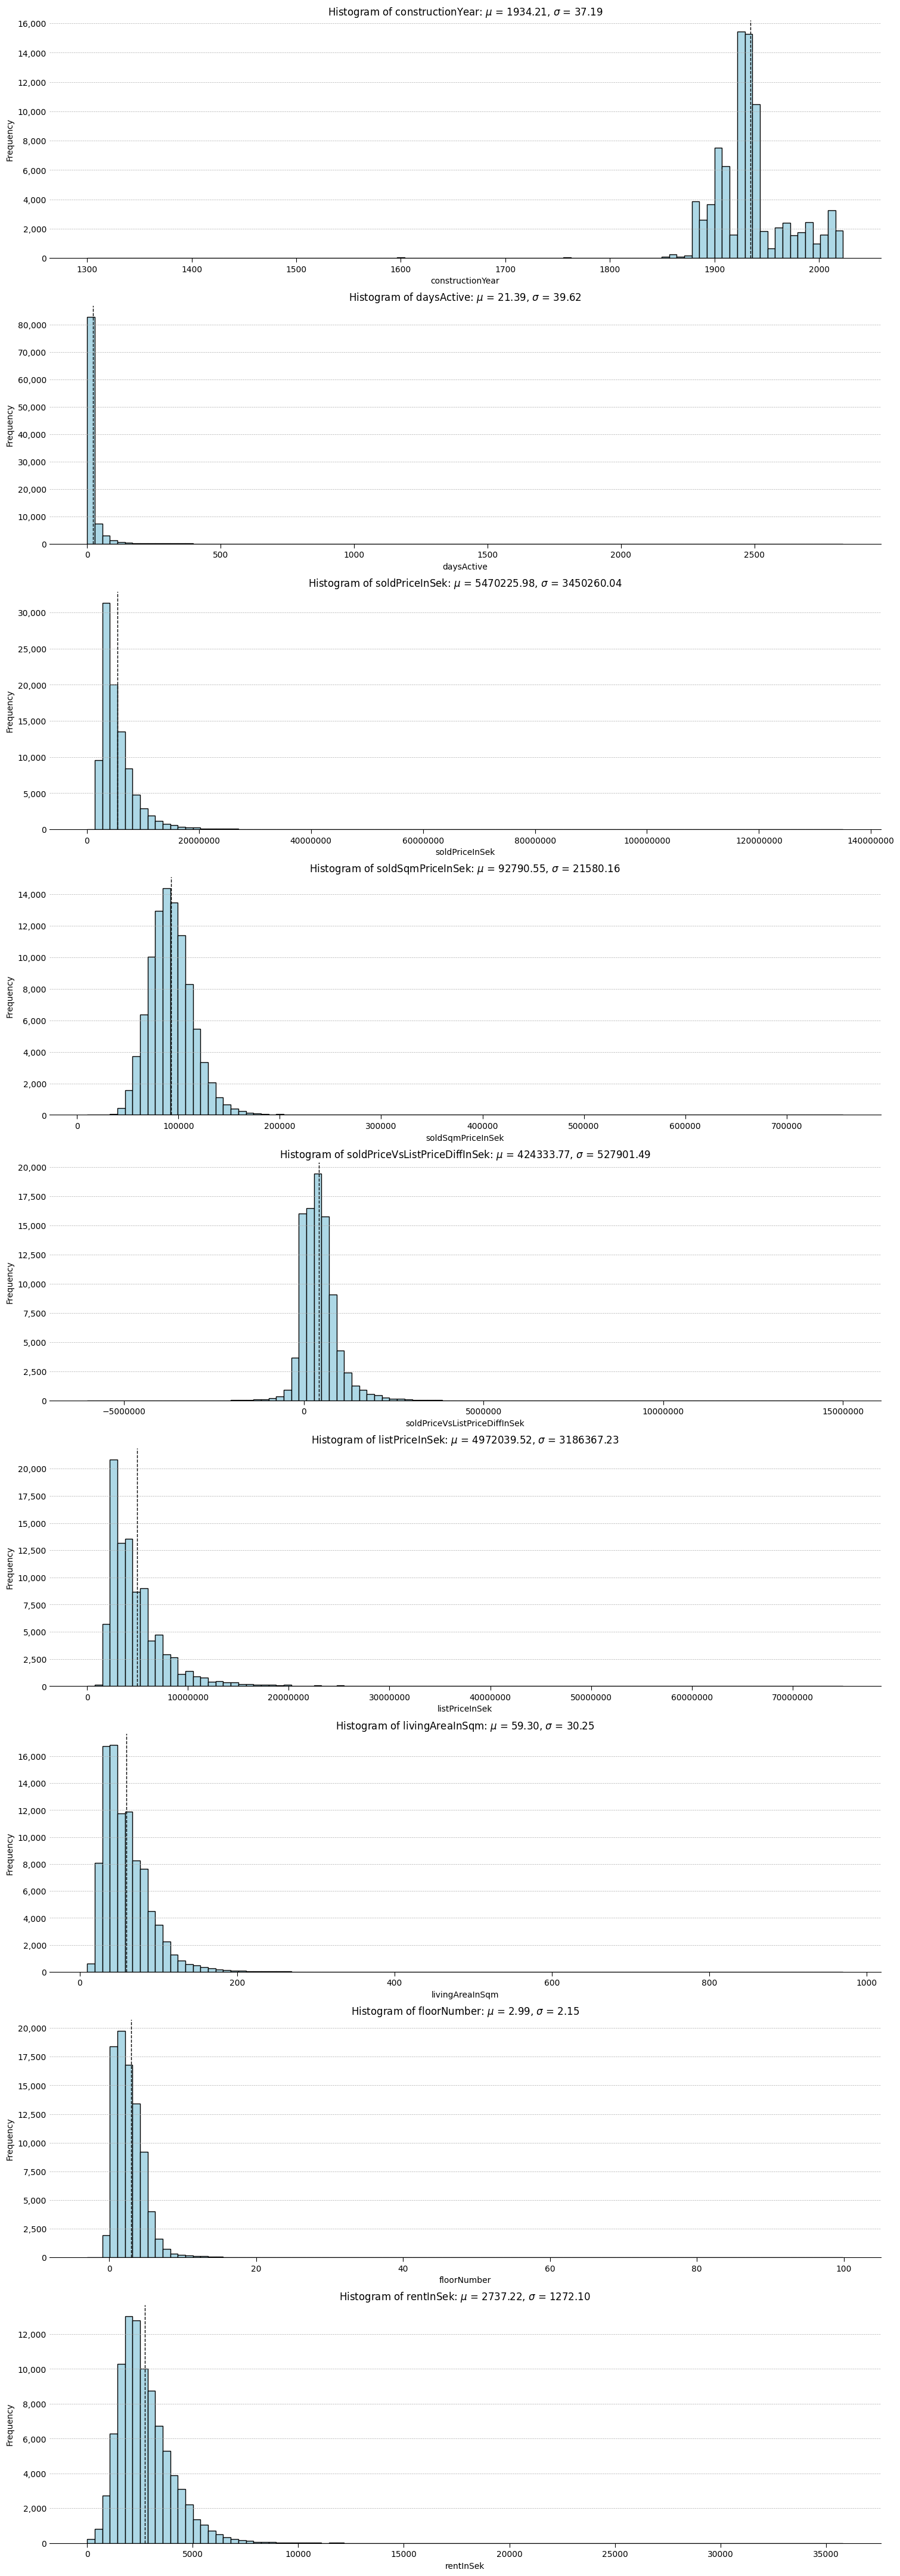

In [48]:
fig, axs = plt.subplots(nrows = 9, figsize = (18,55))

plot_distribution(df, "constructionYear", axs[0])
plot_distribution(df, "daysActive", axs[1])
plot_distribution(df, "soldPriceInSek", axs[2])
plot_distribution(df, "soldSqmPriceInSek", axs[3])
plot_distribution(df, "soldPriceVsListPriceDiffInSek", axs[4])
plot_distribution(df, "listPriceInSek", axs[5])
plot_distribution(df, "livingAreaInSqm", axs[6])
plot_distribution(df, "floorNumber", axs[7])
plot_distribution(df, "rentInSek", axs[8])

## Sold Date

In [49]:
def plot_dates(dataframe, date_col, measure_col, agg_func = "count"):
    if agg_func == "count":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).count()
    elif agg_func == "sum":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).sum()
    elif agg_func == "mean":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).mean()
    else:
        return print("Choose a correct aggregation function")
        
    ax = temp.plot(kind = "line", figsize = (25, 10))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    plt.show()

### Sold Objects

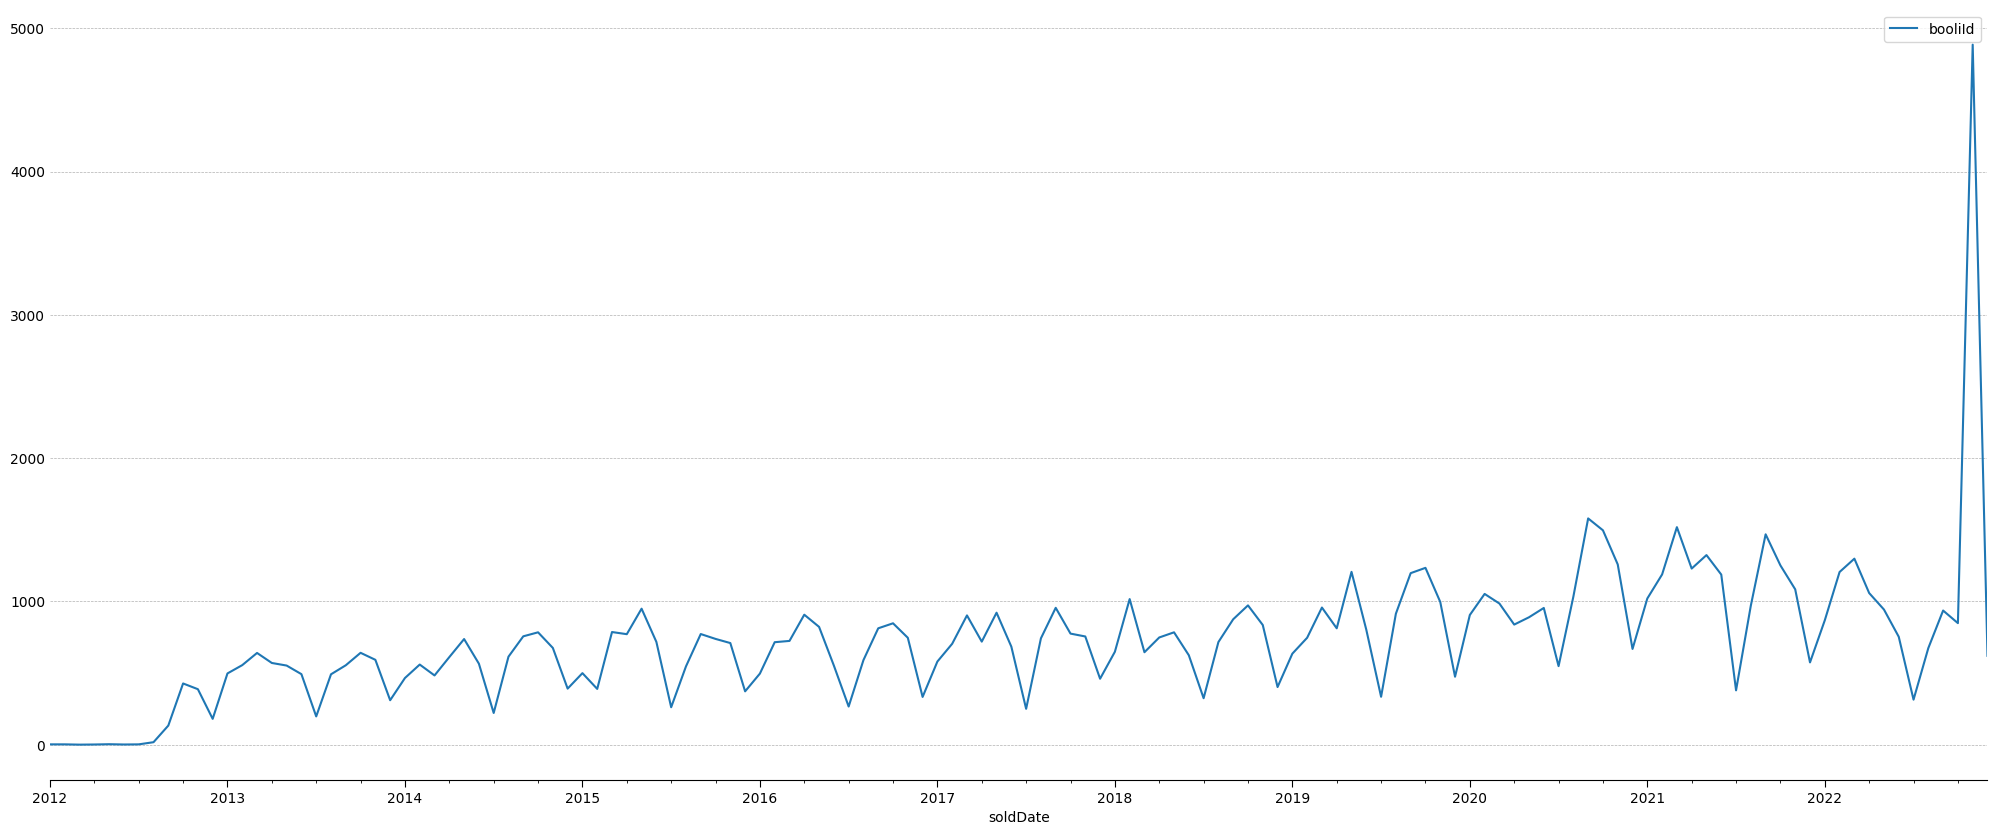

In [50]:
df["soldDate"] = pd.to_datetime(df["soldDate"], format = "%Y-%m-%d")
plot_dates(df, "soldDate", "booliId", "count")

### Mean Days Active

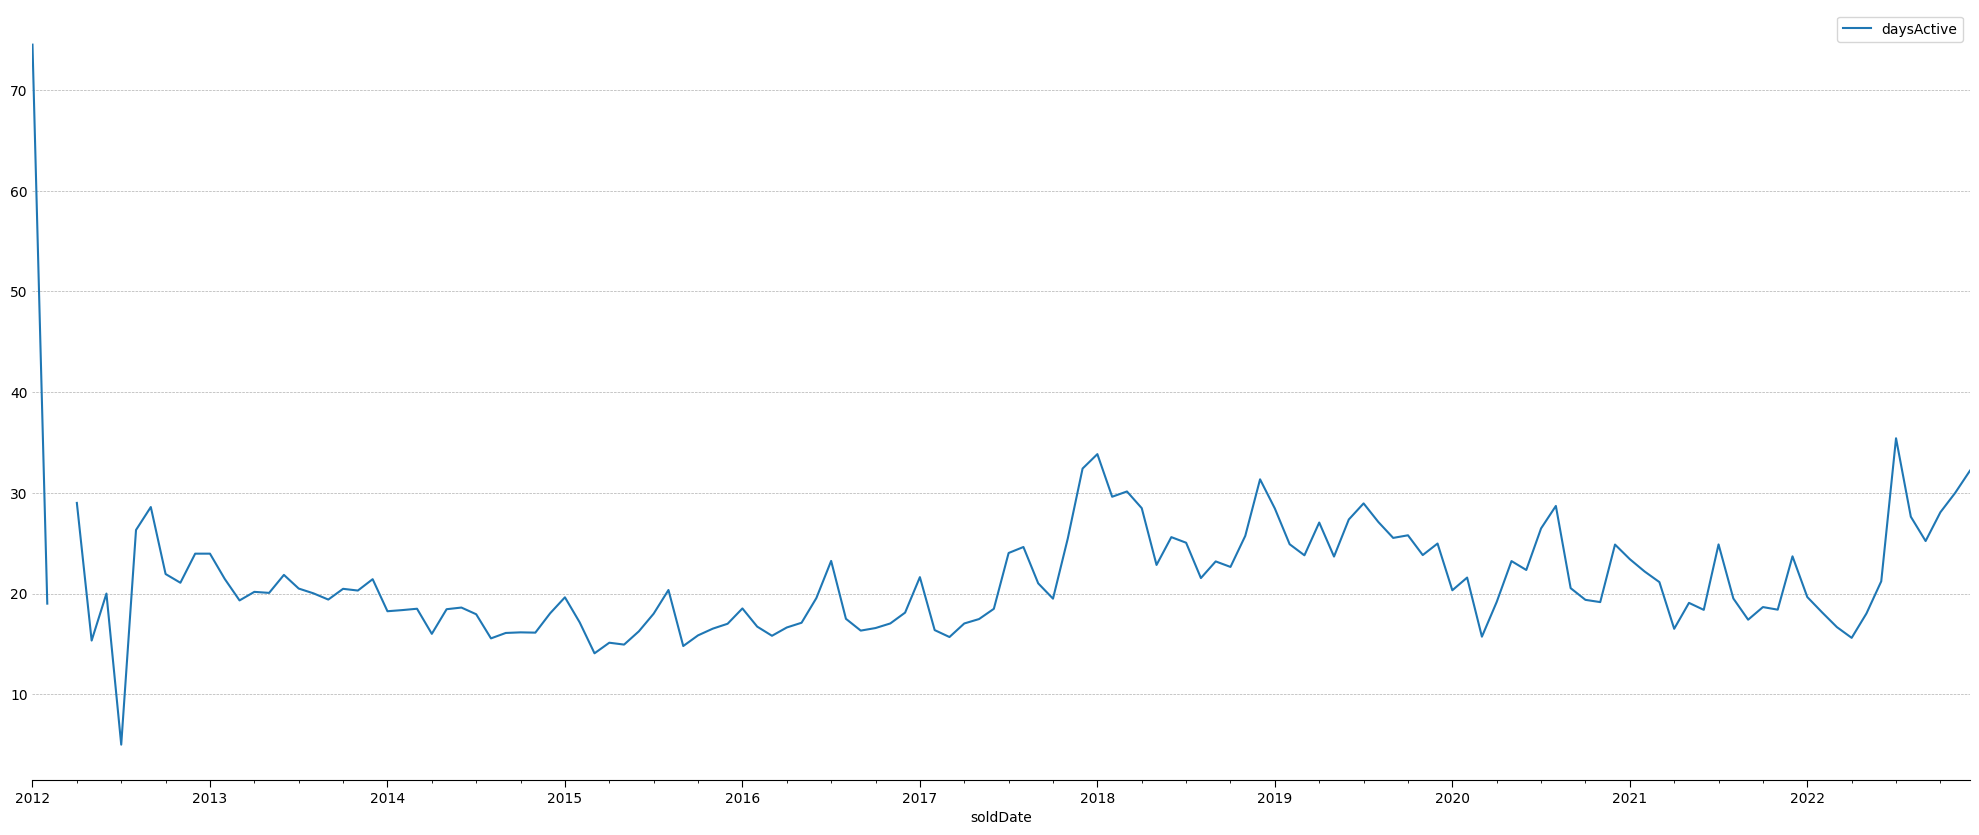

In [51]:
plot_dates(df, "soldDate", "daysActive", "mean")

### Mean Sold Sqm Price in Sek

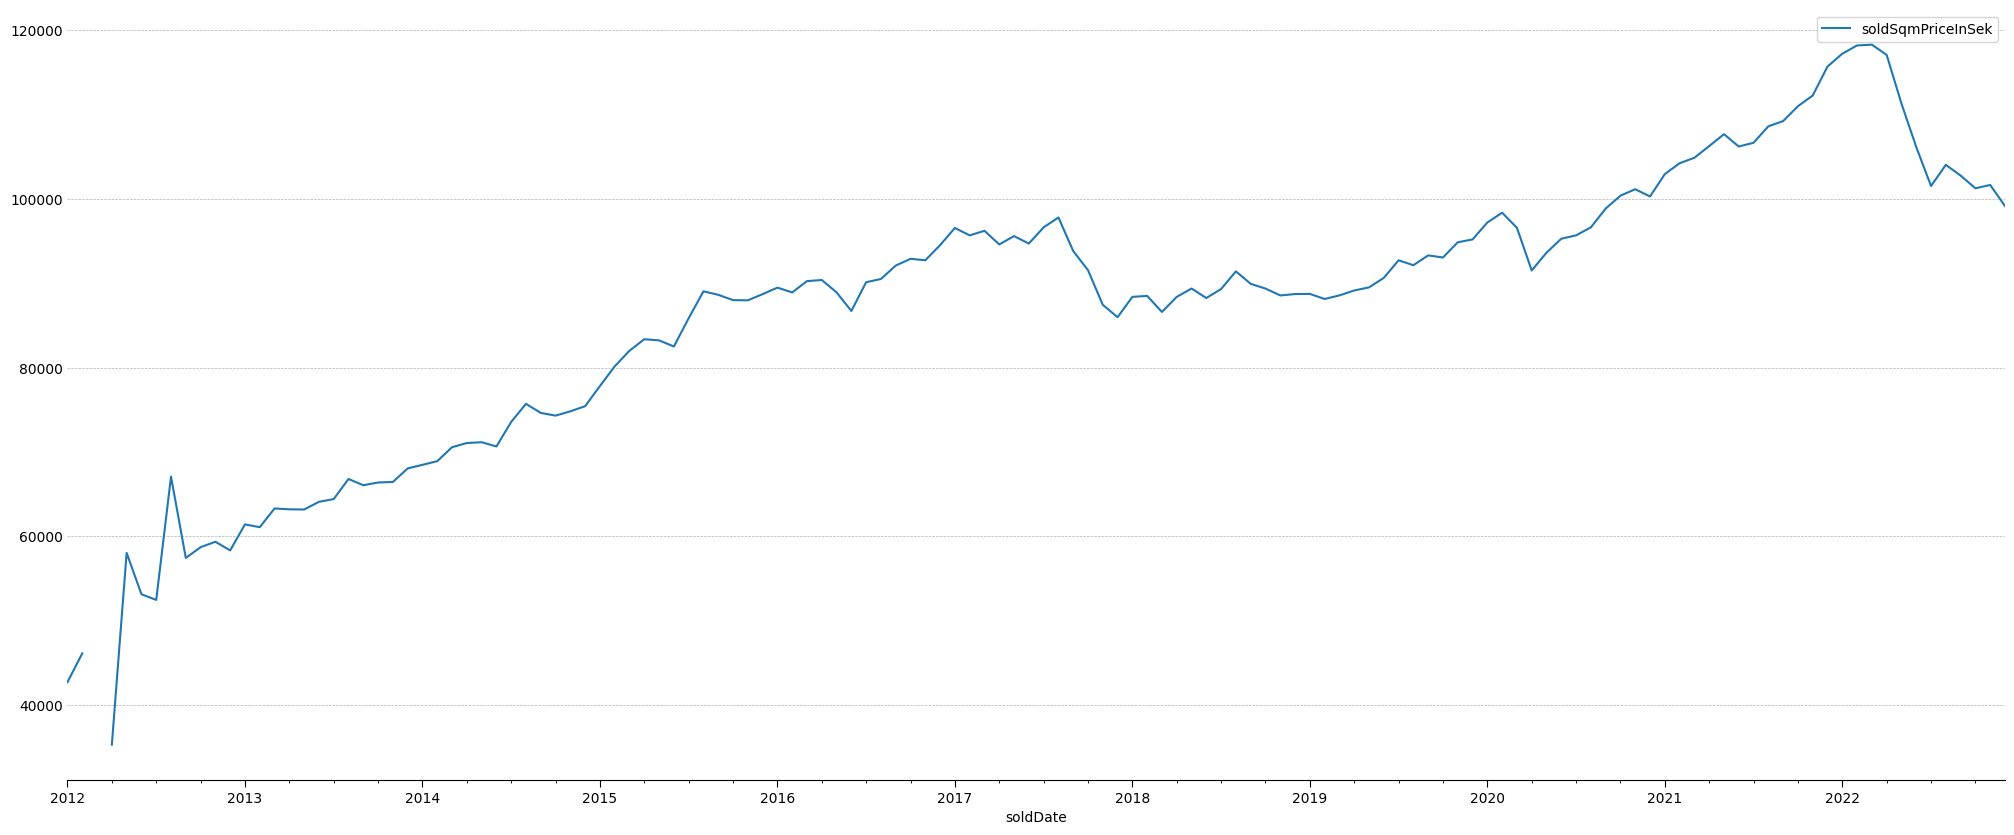

In [52]:
plot_dates(df, "soldDate", "soldSqmPriceInSek", "mean")

### Mean Sold Sqm Price in Sek per Number of Rooms

<AxesSubplot: xlabel='soldDate'>

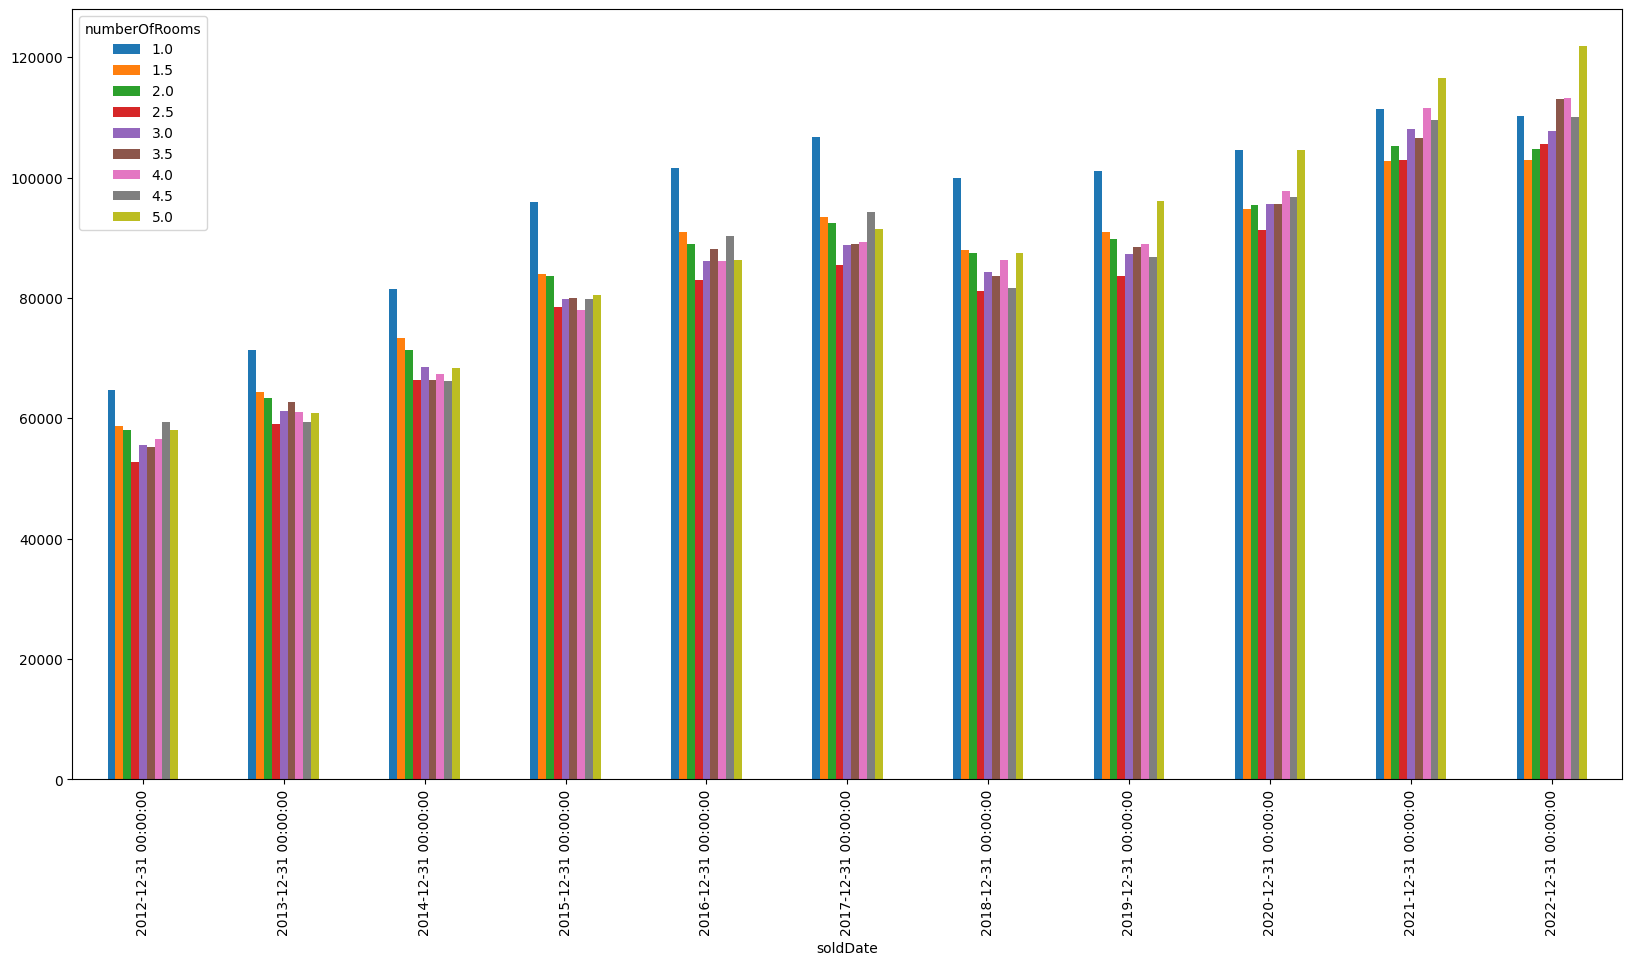

In [53]:
df_sqm_rooms = df[["soldDate", "soldSqmPriceInSek", "numberOfRooms"]].set_index("soldDate").groupby([pd.Grouper(freq = "Y"), "numberOfRooms"])["soldSqmPriceInSek"].mean().reset_index()
df_sqm_rooms = df_sqm_rooms[df_sqm_rooms.numberOfRooms <= 5]
df_sqm_rooms.pivot(index = "soldDate", columns = "numberOfRooms", values = "soldSqmPriceInSek").plot(kind = "bar", figsize = (20, 10))

### Monthly Average Sqm Price in Sek Per Descriptive Area Name

In [54]:
df[["descriptiveAreaName", "booliId"]].groupby(["descriptiveAreaName"]).count().sort_values(by = "booliId", ascending = False).head(30)

,booliId
descriptiveAreaName,
Vasastan,18917
Kungsholmen,17932
Södermalm,16225
Östermalm,10611
Gärdet,4091
Katarina,1478
Södermalm Katarina,1099
Essingeöarna,1035
Norrmalm,976


In [55]:
df_area_price = df[["soldDate", "descriptiveAreaName", "soldSqmPriceInSek"]].set_index("soldDate")
df_area_price = df_area_price[df_area_price.descriptiveAreaName.isin(["Vasastan", "Kungsholmen", "Södermalm", "Östermalm"])]
df_area_price = df_area_price[df_area_price.index >= "2012-12-31"]
df_area_price = df_area_price.groupby([pd.Grouper(freq = "M"), "descriptiveAreaName"]).mean().reset_index()
df_area_price = df_area_price.pivot(index = "soldDate", columns = "descriptiveAreaName", values = "soldSqmPriceInSek")
df_area_price["Mean"] = df_area_price.mean(axis = 1)

In [56]:
df_area_price.reset_index().head()

descriptiveAreaName,soldDate,Kungsholmen,Södermalm,Vasastan,Östermalm,Mean
0,2013-01-31,59320.109756,60340.608108,66087.478261,66009.318182,62939.378577
1,2013-02-28,56972.075269,59304.747253,65676.434783,67216.384615,62292.410480
2,2013-03-31,61103.741071,61005.252874,66525.214953,70012.962963,64661.792965
3,2013-04-30,61214.252525,62196.533333,67286.456311,69905.116279,65150.589612
4,2013-05-31,62088.827957,61526.765432,65177.415584,72397.000000,65297.502243


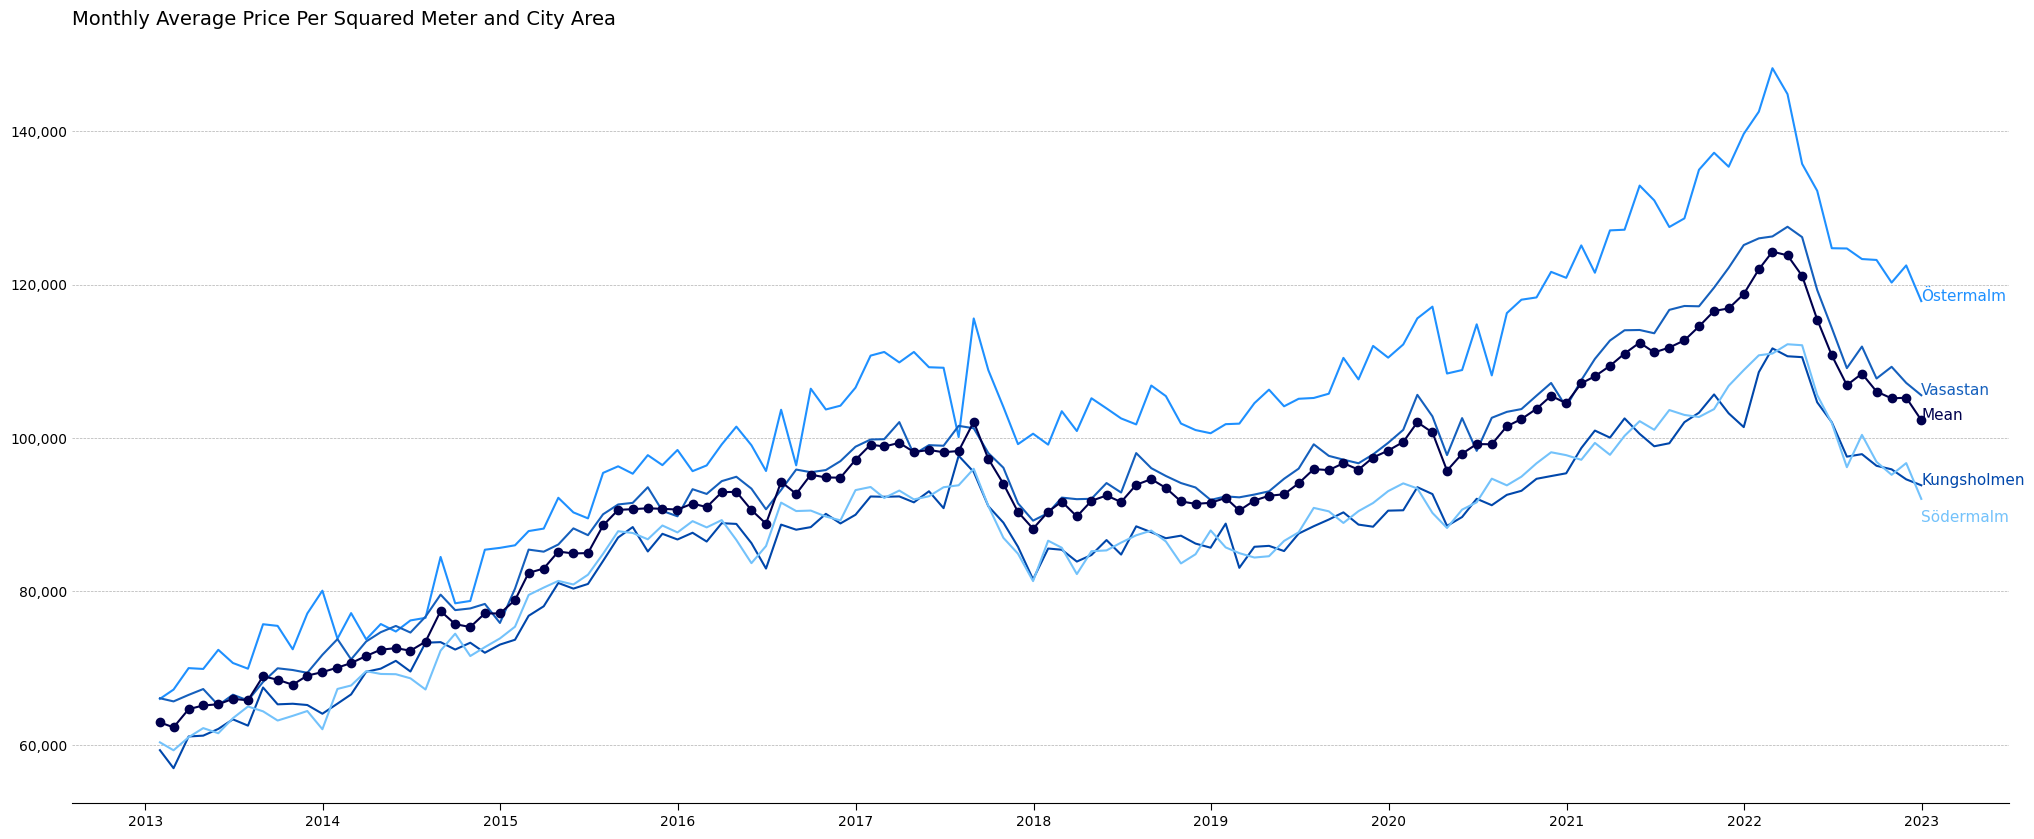

In [65]:
def plot_sqm_price_per_date(dataframe, ax):
    
    color_tableau = {
        "Kungsholmen": "#0047ab",
        "Östermalm": "#1E90FF",
        "Södermalm": "#73c2fb",
        "Vasastan": "#1560BD",
        "Mean": "#00004d"
    }
    
    temp = dataframe

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    for area, color in color_tableau.items():
        if area == "Mean":
            plt.plot(temp["soldDate"].values, 
                    temp[area].values, 
                    lw = 1.5,
                    linestyle = "-",
                    marker = "o",
                    color = color)
        else:
            plt.plot(temp["soldDate"].values, 
                    temp[area].values, 
                    lw = 1.5, 
                    color = color)
            
        y_pos = temp[area].values[-1] - 0.5
        if area == "Södermalm":    
            y_pos += -3000
            
        plt.text(temp.soldDate.max(), y_pos, area, fontsize = 11, color = color) 
            
    ax.set_title("Monthly Average Price Per Squared Meter and City Area", loc = "left", fontsize = 14)



plt.figure(figsize = (25, 10))
ax = plt.subplot(111)
plot_sqm_price_per_date(df_area_price.reset_index(), ax)




# 5. Data Cleaning

## Drop nan Columns

In [76]:
def get_nan_per_column(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(len(df))
    print('\n')
    print(missing_data)


get_nan_per_column(df)

93503


                                      Total   Percent
floorNumber                            9262  0.099056
constructionYear                       8250  0.088232
soldPriceVsListPriceDiffInPercentage   3471  0.037122
soldPriceVsListPriceDiffInSek          3471  0.037122
listPriceInSek                         3458  0.036983
rentInSek                              2620  0.028020
daysActive                              563  0.006021
numberOfRooms                           247  0.002642
livingAreaInSqm                         142  0.001519
soldSqmPriceInSek                       142  0.001519
soldPriceInSek                            0  0.000000
booliId                                   0  0.000000
streetAddress                             0  0.000000
longitude                                 0  0.000000
latitude                                  0  0.000000
soldDate                                  0  0.000000
soldPriceType                             0  0.000000
descriptiveAreaName 

In [77]:
df = df.dropna()
get_nan_per_column(df)

72383


                                      Total  Percent
booliId                                   0      0.0
streetAddress                             0      0.0
numberOfRooms                             0      0.0
livingAreaInSqm                           0      0.0
listPriceInSek                            0      0.0
soldPriceVsListPriceDiffInPercentage      0      0.0
soldPriceVsListPriceDiffInSek             0      0.0
soldSqmPriceInSek                         0      0.0
rentInSek                                 0      0.0
soldPriceInSek                            0      0.0
url                                       0      0.0
longitude                                 0      0.0
latitude                                  0      0.0
soldDate                                  0      0.0
daysActive                                0      0.0
soldPriceType                             0      0.0
descriptiveAreaName                       0      0.0
objectType                            

## Drop Dates with Few Data Points

In [78]:
df[["soldDate", "booliId"]].set_index("soldDate").groupby([pd.Grouper(freq = "M")])["booliId"].count().reset_index().sort_values("soldDate", ascending = True).head(30)


,soldDate,booliId
0,2012-05-31,1
1,2012-06-30,1
2,2012-07-31,0
3,2012-08-31,10
4,2012-09-30,67
5,2012-10-31,154
6,2012-11-30,149
7,2012-12-31,68
8,2013-01-31,189
9,2013-02-28,250


In [79]:
df = df[df.soldDate >= "2012-09-30"]
df = df.set_index("booliId")
df.sort_values("soldDate", ascending = True).head(30)

,streetAddress,constructionYear,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber
booliId,,,,,,,,,,,,,,,,,,,
1270221,Birkagatan 4,1927.0,Lägenhet,Vasastan,Sista bud,17.0,2012-09-30,59.339253,18.032454,/bostad/582830,3470000,2226.0,73830.0,375000.0,12.1,3095000.0,47.0,2.0,3.0
1181045,Tulegatan 5B,1891.0,Lägenhet,Vasastan,Sista bud,17.0,2012-09-30,59.341318,18.062897,/annons/1181045,6425000,7141.0,53099.0,25000.0,0.4,6400000.0,121.0,4.0,4.0
1271226,Essinge Brogata 22,1939.0,Lägenhet,Kungsholmen,Sista bud,16.0,2012-09-30,59.325085,18.004440,/annons/1271226,1320000,2109.0,44000.0,25000.0,1.9,1295000.0,30.0,1.0,1.0
1270454,Birger Jarlsgatan 111C,1906.0,Lägenhet,Vasastan,Sista bud,16.0,2012-09-30,59.348773,18.058659,/annons/1270454,3550000,2369.0,61207.0,50000.0,1.4,3500000.0,58.0,2.0,2.0
1273715,Strålgatan 23,1938.0,Lägenhet,Kungsholmen,Sista bud,12.0,2012-09-30,59.324080,18.005720,/bostad/752081,1600000,2259.0,50000.0,100000.0,6.7,1500000.0,32.0,1.0,3.0
1263985,Bysistorget 6,1932.0,Lägenhet,Södermalm,Sista bud,24.0,2012-09-30,59.318382,18.055773,/annons/1263985,2600000,1841.0,59908.0,5000.0,0.2,2595000.0,43.4,2.0,2.0
1265007,Observatoriegatan 9,1881.0,Lägenhet,Vasastan,Sista bud,24.0,2012-10-01,59.340581,18.051606,/annons/1265007,3400000,3065.0,57627.0,-200000.0,-5.6,3600000.0,59.0,2.0,2.0
1272464,Upplandsgatan 19B,1887.0,Lägenhet,Vasastan,Sista bud,16.0,2012-10-02,59.338388,18.052430,/annons/1272464,5000000,4230.0,59524.0,-500000.0,-9.1,5500000.0,84.0,2.0,4.0
1269285,Dalagatan 23,1882.0,Lägenhet,Vasastan,Sista bud,19.0,2012-10-02,59.343334,18.043790,/annons/1269285,5810000,2493.0,65281.0,10000.0,0.2,5800000.0,89.0,3.5,2.0


# 6. Saving Cleaned Data to Pickle

In [80]:
# parquet_file = df.to_parquet(index = False)
# azure_utils.upload_csv_to_datalake(df, f"silver/sold_clean", f"Sold_{date.today()}.csv")
df.to_pickle("cleaned.pkl")